# XU Method – Entropy-Based Anomaly Detection on CTU-13

Ce Notebook démontre l'approche XU, basée sur l'entropie, sur un dataset de type CTU-13.

## Fonctions utilisées

### 1. Import & Setup

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm
import json
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go
%matplotlib inline
sns.set()
print("Libraries loaded.")

#Fonction pour afficher les données
from IPython.display import display, HTML

def display_scrollable_dataframe(df, max_height=400):
    display(HTML(df.to_html(notebook=True)))
    display(HTML(f"""
    <style>
    table {{
        display: block;
        max-height: {max_height}px;
        overflow-y: scroll;
        border: 1px solid #ccc;
    }}
    </style>
    """))



Libraries loaded.


### Chargements des données et Preprocessing

In [155]:
def load_data(data_path):
    df = pd.read_csv(data_path, sep=',', on_bad_lines='skip')
    print(f"Data shape: {df.shape}")
    return df

In [156]:
def preprocess_binetflows(df, timewindow='2min'):
    """
    Prétraitement standardisé du dataset NetFlow pour analyse XU et classification.

    - Renomme les colonnes au format standard.
    - Nettoie les labels (Botnet / Normal / Background).
    - Sauvegarde l’ancien label dans 'Label_description'.
    - Crée une colonne 'TimeWindow' pour regroupement temporel.

    Paramètres :
    - df : DataFrame brut
    - timewindow : taille de la fenêtre temporelle pour la colonne 'TimeWindow' (ex: '2min', '5min', '10min')

    Retour :
    - df_clean : DataFrame nettoyé, formaté, prêt pour XU
    """

    print("🔧 Renommage des colonnes au format standard (sans toucher à 'State', 'sTos', 'dTos', etc)...")
    rename_map = {
        'StartTime': 'flow_start',
        'Dur': 'Durat',
        'Proto': 'Prot',
        'SrcAddr': 'SrcIP',
        'Sport': 'SrcPort',
        'Dport': 'DstPort',
        'Dir': 'Direc',
        'DstAddr': 'DstIP'
    }

    df_clean = df.rename(columns=rename_map)

    print("📋 Sauvegarde du label d'origine dans 'Label_description'...")
    df_clean['Label_description'] = df_clean['Label'].astype(str)

    print("🧼 Nettoyage des labels (uniquement Background, Normal, Botnet)...")
    df_clean['Label'] = df_clean['Label_description'].apply(lambda x: (
        'Botnet' if 'Botnet' in x else
        'Normal' if 'Normal' in x else
        'Background'
    ))

    if not pd.api.types.is_datetime64_any_dtype(df_clean['flow_start']):
        print("📅 Conversion de 'flow_start' en datetime...")
        df_clean['flow_start'] = pd.to_datetime(df_clean['flow_start'], errors='coerce')

    print(f"🕒 Création de la colonne 'TimeWindow' avec une granularité = '{timewindow}'...")
    df_clean['TimeWindow'] = df_clean['flow_start'].dt.floor(timewindow)

    print("✅ Dataset prêt pour les traitements XU et classification.")
    return df_clean


In [157]:
def count_ip_per_label(df):
    """
    Affiche combien d'adresses IP distinctes sont taguées Normal, Background ou Botnet.
    """
    counts = df.groupby('Label')['SrcIP'].nunique()
    print("📊 Nombre d'adresses IP distinctes par Label :")
    for label in ['Normal', 'Background', 'Botnet']:
        print(f"  ➤ {label}: {counts.get(label, 0)} IP")
    return counts


In [158]:
def hist_of_label_values(df):
    """
    Affiche un histogramme de la répartition des labels dans le DataFrame,
    avec les pourcentages affichés sur les barres.
    
    Paramètres :
    - df : pd.DataFrame contenant une colonne 'Label' avec les valeurs 
           'Background', 'Normal' et 'Botnet'.
    
    Affichage :
    - Un histogramme avec les pourcentages sur les barres.
    - Un dictionnaire affiché contenant les pourcentages.
    """
    # Regroupement des valeurs
    label_values = df['Label'].value_counts()

    # Somme des catégories
    background_count = sum(label_values[label] for label in label_values.index if "Background" in label)
    normal_count = sum(label_values[label] for label in label_values.index if "Normal" in label)
    botnet_count = sum(label_values[label] for label in label_values.index if "Botnet" in label)
    
    # Dictionnaire des comptages
    label_repartition = {
        "Background traffic": background_count, 
        "Normal traffic": normal_count, 
        "Botnet traffic": botnet_count
    }

    # Calcul du total et des pourcentages
    total_traffic = sum(label_repartition.values())
    percentage_of_traffic = {k: round((v / total_traffic) * 100, 2) for k, v in label_repartition.items()}

    # Affichage de l'histogramme
    fig, ax = plt.subplots(figsize=(7,5))
    bars = ax.bar(label_repartition.keys(), label_repartition.values(), color=['gray', 'blue', 'red'])

    # Ajout des pourcentages au-dessus des barres
    for bar in bars:
        height = bar.get_height()
        percentage = (height / total_traffic) * 100
        ax.text(bar.get_x() + bar.get_width()/2, height + total_traffic * 0.02, 
                f"{percentage:.2f}%", ha='center', fontsize=12, fontweight='bold')

    # Amélioration du visuel
    ax.set_ylabel("Nombre de flux", fontsize=12)
    ax.set_title("Répartition du trafic par catégorie", fontsize=14, fontweight='bold')
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.show()


In [159]:
def plot_label_distribution_separated(df_classified_netflows, time_col='TimeWindow', x_tick_spacing=5, label_to_show=['Botnet', 'Normal', 'Background']):
    """
    Affiche un graphe séparé (non empilé) du nombre de flux pour chaque label par TimeWindow.

    Paramètres :
    - df_classified_netflows : DataFrame contenant 'TimeWindow' et 'Label'
    - time_col : nom de la colonne temporelle (par défaut 'TimeWindow')
    - x_tick_spacing : espacement des ticks X (ex: 5 = 1 tick toutes les 5 TimeWindows)
    """
    print("📊 ➤ Calcul de la distribution des labels par TimeWindow (graphes séparés)...")

    # Conversion TimeWindow en label lisible
    df_classified_netflows['TimeLabel'] = df_classified_netflows[time_col].dt.strftime('%H:%M')

    # Comptage des labels par TimeWindow
    label_counts = df_classified_netflows.groupby(['TimeLabel', 'Label']).size().unstack(fill_value=0)

    # Ajouter les labels manquants si nécessaire
    for label in label_to_show:
        if label not in label_counts.columns:
            label_counts[label] = 0

    label_counts = label_counts[label_to_show]

    # Création des sous-graphes
    n = len(label_to_show)
    fig, axes = plt.subplots(n, 1, figsize=(18, 4 * n), sharex=False)

    if n == 1:
        axes = [axes]

    # Espacement des ticks X
    x_ticks = np.arange(0, len(label_counts), x_tick_spacing)
    x_labels = label_counts.index[x_ticks]

    for i, label in enumerate(label_to_show):
        axes[i].bar(label_counts.index, label_counts[label], color=('red' if label == 'Botnet' else 'blue' if label == 'Normal' else 'gray'))
        axes[i].set_title(f"Activité '{label}' au fil du temps", fontsize=14)
        axes[i].set_ylabel("Nombre de flux")
        axes[i].grid(True, axis='y', linestyle='--', alpha=0.6)
        axes[i].set_xticks(x_ticks)
        axes[i].set_yscale('log')
        axes[i].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
        axes[i].set_xlabel("Heure (TimeWindow)", fontsize=12)
    plt.tight_layout()
    plt.show()



In [ ]:
def plot_label_distribution_separated(df_classified_netflows, time_col='TimeWindow', x_tick_spacing=5, label_to_show=['Botnet', 'Normal', 'Background']):
    """
    Affiche des histogrammes séparés (non empilés entre labels, mais empilés par protocole) par TimeWindow.
    Chaque sous-graphique correspond à un Label, avec coloration fixée pour TCP, UDP, ICMP.
    """

    print("📊 ➤ Calcul de la distribution des labels+protocoles par TimeWindow...")

    # Conversion TimeWindow en label lisible pour affichage
    df_classified_netflows['TimeLabel'] = df_classified_netflows[time_col].dt.strftime('%H:%M')

    # Liste complète des TimeLabels (X-axis uniformisée)
    all_timelabels = df_classified_netflows['TimeLabel'].sort_values().unique()

    # Regroupement : nombre de flux par TimeLabel, Label, Prot
    grouped = df_classified_netflows.groupby(['TimeLabel', 'Label', 'Prot']).size().reset_index(name='Count')

    # Fixer les couleurs par protocole
    prot_color_map = {
        'tcp': (0/255, 114/255, 189/255),     # bleu
        'udp': (217/255, 83/255, 25/255),     # orange
        'icmp': (119/255, 172/255, 48/255)    # vert
    }

    unique_prots = sorted(df_classified_netflows['Prot'].unique())

    # Ajouter couleur grise pour les autres protocoles
    for prot in unique_prots:
        if prot not in prot_color_map:
            prot_color_map[prot] = 'lightgray'

    # Création des subplots
    n = len(label_to_show)
    fig, axes = plt.subplots(n, 1, figsize=(18, 4 * n), sharex=False)

    if n == 1:
        axes = [axes]

    for i, label in enumerate(label_to_show):
        df_label = grouped[grouped['Label'] == label]

        # Pivot table : index = TimeLabel, colonnes = Prot, valeurs = Count
        pivot = df_label.pivot(index='TimeLabel', columns='Prot', values='Count').reindex(all_timelabels).fillna(0)

        x = np.arange(len(all_timelabels))
        x_ticks = x[::x_tick_spacing]
        x_labels = all_timelabels[x_ticks]

        bottom = np.zeros(len(pivot))
        for prot in unique_prots:
            if prot in pivot.columns:
                axes[i].bar(x, pivot[prot], bottom=bottom, label=prot, color=prot_color_map[prot])
                bottom += pivot[prot].values

        axes[i].set_title(f"Activité '{label}' par protocole au fil du temps", fontsize=14)
        axes[i].set_ylabel("Nombre de flux (log)", fontsize=12)
        axes[i].set_yscale('log')
        axes[i].set_xticks(x_ticks)
        axes[i].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
        axes[i].grid(axis='y', linestyle='--', alpha=0.6)
        axes[i].legend(title="Protocole", fontsize=10)
        axes[i].set_xlabel("Heure (TimeWindow)", fontsize=12)

    plt.tight_layout()
    plt.show()


In [204]:
def plot_label_distribution_ports_touched(df_classified_netflows, time_col='TimeWindow', x_tick_spacing=5, label_to_show=['Botnet', 'Normal', 'Background']):
    """
    Affiche des histogrammes séparés par Label, indiquant le nombre de ports distincts (DstPort)
    touchés dans chaque TimeWindow, sans distinction de protocole (toutes barres même couleur).
    """

    print("📊 ➤ Calcul du nombre de ports distincts par TimeWindow et Label...")

    # Création d'une colonne lisible pour l'affichage du temps
    df_classified_netflows['TimeLabel'] = df_classified_netflows[time_col].dt.strftime('%H:%M')

    # Liste des TimeLabels dans l’ordre
    all_timelabels = df_classified_netflows['TimeLabel'].sort_values().unique()

    # Groupement : nombre de ports uniques par TimeLabel et Label (on ignore le protocole ici)
    grouped_ports = df_classified_netflows.groupby(['TimeLabel', 'Label'])['DstPort'].nunique().reset_index(name='DistinctPorts')

    # Création des subplots
    n = len(label_to_show)
    fig, axes = plt.subplots(n, 1, figsize=(18, 4 * n), sharex=False)
    if n == 1:
        axes = [axes]

    for i, label in enumerate(label_to_show):
        df_label = grouped_ports[grouped_ports['Label'] == label]

        # Pivot : TimeLabel en index, valeurs = nombre de ports
        pivot = df_label.set_index('TimeLabel').reindex(all_timelabels).fillna(0)

        x = np.arange(len(all_timelabels))
        x_ticks = x[::x_tick_spacing]
        x_labels = all_timelabels[x_ticks]

        # Tracer une seule barre par TimeWindow (sans empilement)
        axes[i].bar(x, pivot['DistinctPorts'], color='steelblue', width=0.6)

        axes[i].set_title(f"Nombre de ports (DstPort) différents – {label}", fontsize=14)
        axes[i].set_ylabel("Ports distincts", fontsize=12)
        axes[i].set_xticks(x_ticks)
        axes[i].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
        axes[i].grid(axis='y', linestyle='--', alpha=0.6)

        # Fixer l’axe Y pour Botnet et Normal uniquement
        if label in ['Botnet', 'Normal']:
            axes[i].set_ylim(0, 16)

        axes[i].set_xlabel("Heure (TimeWindow)", fontsize=12)

    plt.tight_layout()
    plt.show()


### Algorithme XU

#### Algorithme d'extraction des clusters significatif par rapport à l'IP

In [161]:
def compute_relative_uncertainty(prob_dist):
    probs = np.array(prob_dist)
    if len(probs) <= 1:
        return 0.0
    entropy = -np.sum(probs * np.log2(probs + 1e-12))
    max_entropy = np.log2(len(probs))
    return entropy / max_entropy

def extract_significant_clusters(df, time_col='TimeWindow', column='SrcIP', alpha0=0.02, beta=0.9,
                                 stop_while=50, debug=False, progress=True):
    """
    Applique l’algorithme d’extraction de clusters significatifs (Entropy-based) pour chaque TimeWindow.

    Paramètres :
    - df : DataFrame NetFlow
    - time_col : colonne temporelle (par ex. 'TimeWindow')
    - column : colonne sur laquelle détecter les clusters (par ex. 'SrcIP')
    - alpha0 : seuil initial alpha
    - beta : seuil RU à atteindre
    - stop_while : max itérations while (sécurité)
    - debug : affiche les détails de chaque itération
    - progress : affiche une barre de progression tqdm (par défaut True)

    Retour :
    - df_clustered_all : DataFrame avec la colonne ClusterType (Significatif/Bruit)
    - df_log_all : log global (DataFrame) de l’évolution de l’algorithme par TimeWindow
    """

    df_list = []
    log_list = []

    all_timewindows = df[time_col].dropna().unique()
    all_timewindows = sorted(all_timewindows)

    if progress:
        print(f"🔁 ➤ Traitement de {len(all_timewindows)} TimeWindows...")

    iterator = tqdm(all_timewindows, desc="Extraction clusters par TimeWindow") if progress else all_timewindows

    for t in iterator:
        df_t = df[df[time_col] == t].copy()
        freqs = df_t[column].value_counts(normalize=True)
        A = freqs.index.tolist()
        PA = freqs.to_dict()

        S = set()
        R = set(A)
        k = 0
        alpha = alpha0

        PR = [PA[val] for val in R]
        theta = compute_relative_uncertainty(PR)

        log_local = []
        while theta <= beta and stop_while > k:
            alpha = alpha0 * (0.5 ** k)
            k += 1

            move_to_S = {val for val in R if PA[val] >= alpha}
            S.update(move_to_S)
            R -= move_to_S

            PR_probs = [PA[val] for val in R]
            PR_probs = np.array(PR_probs)
            PR_probs = PR_probs / PR_probs.sum() if PR_probs.sum() > 0 else np.array([1.0])
            theta = compute_relative_uncertainty(PR_probs)

            log_local.append({
                'TimeWindow': t,
                'Iteration': k,
                'Alpha': alpha,
                'RU_remaining': theta,
                'Total_Values': len(A),
                'Significant_Values': len(S)
            })

            if debug and k % 5 == 0:
                print(f"[⏱ {t}] Iteration {k} | Alpha: {round(alpha, 4)} | RU: {round(theta, 4)} | S={len(S)}")

        df_t['ClusterType'] = df_t[column].apply(lambda x: 'Significatif' if x in S else 'Bruit')
        df_list.append(df_t)
        df_log_t = pd.DataFrame(log_local)
        log_list.append(df_log_t)

    df_clustered_all = pd.concat(df_list, ignore_index=True)
    df_log_all = pd.concat(log_list, ignore_index=True)

    if progress:
        print("✅ Extraction terminée sur toutes les TimeWindows.")
    return df_clustered_all, df_log_all


In [ ]:
import matplotlib.pyplot as plt

def plot_significant_cluster_evolution(df_log_all, x_tick_spacing=5):
    """
    Affiche l'évolution du nombre de clusters significatifs par TimeWindow.

    Paramètres :
    - df_log_all : DataFrame retourné par extract_significant_clusters (log global)
    - x_tick_spacing : espacement entre les labels X (TimeWindow) sur l’axe X
    """
    print("📈 ➤ Tracé de l'évolution des clusters significatifs...")

    # Récupérer pour chaque TimeWindow la dernière itération (valeurs finales)
    df_summary = df_log_all.sort_values(['TimeWindow', 'Iteration']).groupby('TimeWindow').tail(1)

    # Créer les X et Y
    x = df_summary['TimeWindow']
    y = df_summary['Significant_Values']

    # Tracé
    plt.figure(figsize=(14, 6))
    plt.plot(x, y, marker='o', linestyle='-', label='Clusters significatifs')
    plt.title("Évolution du nombre de clusters significatifs par TimeWindow")
    plt.xlabel("TimeWindow")
    plt.ylabel("Nombre de clusters significatifs")
    plt.grid(True)

    # Espacement des ticks X
    xticks_idx = range(0, len(x), x_tick_spacing)
    plt.xticks(ticks=[x.iloc[i] for i in xticks_idx], labels=[x.iloc[i].strftime("%H:%M") for i in xticks_idx], rotation=45, ha='right')

    plt.tight_layout()
    plt.show()


#### Fonction XU de calcul de distance par rapport aux BC

In [163]:
def normalized_entropy(series):
    counts = series.value_counts(normalize=True, dropna=False)
    entropy = -(counts * np.log2(counts + 1e-12)).sum()
    distinct = len(counts)
    total = len(series)
    if distinct <= 1 or total <= 1:
        return 0.0
    max_entropy = np.log2(min(distinct, total))
    return float(entropy / max_entropy)

def XU_algorithm(df, ref_profiles, time_col='TimeWindow'):
    """
    Version XU avec granularité temporelle (par TimeWindow).
    
    Paramètres :
    - df : DataFrame contenant les colonnes 'SrcIP', 'SrcPort', 'DstPort', 'DstIP', 'Label', 'TimeWindow'
    - ref_profiles : dictionnaire de profils de référence {profil: RU_vector}
    - time_col : nom de la colonne temporelle à utiliser pour le regroupement

    Retour :
    - df_features : DataFrame enrichi avec RU, distances, scores, regroupés par SrcIP et TimeWindow
    """
    results = []
    time_windows = df[time_col].dropna().unique()
    time_windows = sorted(time_windows)

    print(f"🔍 ➤ Traitement XU par TimeWindow ({len(time_windows)} fenêtres)...")

    for t in tqdm(time_windows, desc="XU TimeWindow"):
        df_t = df[df[time_col] == t]
        ip_groups = df_t.groupby('SrcIP')

        for src_ip, df_src in ip_groups:
            ru_srcport = normalized_entropy(df_src['SrcPort'].fillna('N/A'))
            ru_dstport = normalized_entropy(df_src['DstPort'].fillna('N/A'))
            ru_dstip   = normalized_entropy(df_src['DstIP'].fillna('N/A'))

            label = 'Botnet' if 'Botnet' in df_src['Label'].unique() else (
                    'Normal' if 'Normal' in df_src['Label'].unique() else 'Background'
            )

            ru_vector = np.array([ru_srcport, ru_dstport, ru_dstip])

            distances = {}
            for profile_name, profile_vector in ref_profiles.items():
                dist = ((ru_vector - profile_vector) ** 2).sum()
                distances[f'Distance_{profile_name.capitalize()}'] = dist

            anomaly_score = min(distances.values())

            result_row = {
                'TimeWindow': t,
                'SrcIP': src_ip,
                'RU_SrcPort': ru_srcport,
                'RU_DstPort': ru_dstport,
                'RU_DstIP': ru_dstip,
                'AnomalyScore': anomaly_score,
                'Label': label,
                'ClusterType': df_src['ClusterType'].values[0] if 'ClusterType' in df_src.columns else 'N/A'
            }
            result_row.update(distances)
            results.append(result_row)

    df_features = pd.DataFrame(results)
    print("✅ XU par TimeWindow terminé.")
    return df_features


#### Fonctions d'appartenance aux BC

In [164]:
def apply_threshold_and_categorize_ru(df_features, threshold=0.5, epsilon_dict=None, normalize_anomaly=False):
    """
    - Applique le seuil de classification sur la colonne 'Mean_Distance'
    - Catégorise chaque RU en Low (0), Medium (1), High (2) selon epsilon_dict
    - Insère les colonnes RU_*_Level juste après leur colonne RU_* correspondante

    Paramètres :
    - df_features : DataFrame avec les colonnes RU_* et Mean_Distance
    - threshold : seuil pour prédiction de 'Botnet' ou 'Normal'
    - epsilon_dict : dictionnaire des epsilon, ex: {'RU_SrcPort': 0.2, 'RU_DstPort': 0.2, 'RU_DstIP': 0.3}

    Retour :
    - df : DataFrame enrichi avec 'Predicted' + colonnes de niveau
    """

    df = df_features.copy()
    #Normaliser les valeurs de AnomalyScore
    if normalize_anomaly:
        df['AnomalyScore'] = 1 - (df['AnomalyScore'] - 0) / (3 - 0) # Normalisation entre 0 et 1 car l'anomalie est basée sur la distance entre les RU et les profils de référence (0 à 3)
        df['Predicted'] = df['AnomalyScore'].apply(lambda d: 'Botnet' if d > threshold else 'Normal')
    else:
        df['Predicted'] = df['AnomalyScore'].apply(lambda d: 'Botnet' if d < threshold else 'Normal')

    if epsilon_dict is None:
        epsilon_dict = {
            'RU_SrcPort': 0.2,
            'RU_DstPort': 0.2,
            'RU_DstIP': 0.3
        }

    def categorize_ru(ru_value, epsilon):
        if ru_value <= epsilon:
            return 0  # Low
        elif ru_value >= 1 - epsilon:
            return 2  # High
        else:
            return 1  # Medium

    # Insérer chaque RU_Level juste après la RU correspondante
    for col in ['RU_SrcPort', 'RU_DstPort', 'RU_DstIP']:
        if col in df.columns:
            level_col = col + '_Level'
            df[level_col] = df[col].apply(lambda x: categorize_ru(x, epsilon_dict.get(col, 0.2)))
            
            # Réorganiser les colonnes : insérer level_col juste après col
            cols = list(df.columns)
            col_idx = cols.index(col)
            # Retirer puis insérer à la bonne position
            cols.remove(level_col)
            cols.insert(col_idx + 1, level_col)
            df = df[cols]

    return df

#### Fonctions d'affichage des scores d'anomalies

In [165]:
def plot_anomly_distributions(df_classified_pre_clusters, debug=False):
    """
    Affiche les distributions des scores d'anomalie moyens par IP (pondérés sur TimeWindows actifs),
    ainsi que leur ClusterType et Label majoritaires.
    En mode debug, affiche les cas où le fallback est utilisé.
    """
    print("📊 ➤ Calcul du score d'anomalie moyen par IP + Label (Normal prioritaire) et ClusterType majoritaire...")

    fallback_debug_info = []

    def label_priority(x):
        if 'Normal' in x.values:
            return 'Normal'
        mode_val = x.mode()
        if mode_val.empty:
            fallback_debug_info.append({
                'SrcIP': x.name,
                'Column': 'Label',
                'FallbackUsed': True,
                'FallbackValue': x.iloc[0]
            })
            return x.iloc[0]
        return mode_val[0]

    def cluster_mode_fallback(x):
        mode_val = x.mode()
        if mode_val.empty:
            fallback_debug_info.append({
                'SrcIP': x.name,
                'Column': 'ClusterType',
                'FallbackUsed': True,
                'FallbackValue': x.iloc[0]
            })
            return x.iloc[0]
        return mode_val[0]

    df_mean_scores = df_classified_pre_clusters.groupby('SrcIP').agg({
        'AnomalyScore': 'mean',
        'Label': label_priority,
        'ClusterType': cluster_mode_fallback
    }).reset_index()

    count_ip_per_label(df_mean_scores)

    if debug:
        missing_ips = df_classified_pre_clusters[df_classified_pre_clusters['Label'] == 'Normal']['SrcIP'].nunique()
        after_agg_ips = df_mean_scores[df_mean_scores['Label'] == 'Normal']['SrcIP'].nunique()
        initial_labels = df_classified_pre_clusters[df_classified_pre_clusters['Label'] == 'Normal']['SrcIP'].unique()
        post_agg_labels = df_mean_scores[df_mean_scores['Label'] != 'Normal']['SrcIP'].unique()
        ip_lost = set(initial_labels) - set(df_mean_scores[df_mean_scores['Label'] == 'Normal']['SrcIP'])

        print(f"🔎 IP Normal qui ont changé de label après agrégation : {len(ip_lost)}")
        print(ip_lost)
        print(f"➡ Nombre d'IP Normal avant agrégation : {missing_ips}")
        print(f"➡ Nombre d'IP Normal après agrégation : {after_agg_ips}")

        df_debug = pd.DataFrame(fallback_debug_info)
        if not df_debug.empty:
            print("\n⚠️ Mode DEBUG activé - Cas où fallback a été utilisé :")
            display(df_debug)

    # Séparation
    botnet_scores_df = df_mean_scores[df_mean_scores['Label'] == 'Botnet']
    normal_scores_df = df_mean_scores[df_mean_scores['Label'] == 'Normal']
    background_scores_df = df_mean_scores[df_mean_scores['Label'] == 'Background']

    min_score = min(botnet_scores_df['AnomalyScore'].min(),
                    normal_scores_df['AnomalyScore'].min(),
                    background_scores_df['AnomalyScore'].min())

    max_score = max(botnet_scores_df['AnomalyScore'].max(),
                    normal_scores_df['AnomalyScore'].max(),
                    background_scores_df['AnomalyScore'].max())

    fig, axes = plt.subplots(3, 1, figsize=(12, 15))

    sns.histplot(data=botnet_scores_df, x='AnomalyScore', hue='ClusterType', bins=10, kde=False,
                 ax=axes[0], palette={'Significatif': 'red', 'Bruit': 'gray'})
    axes[0].set_title("Distribution des scores d'anomalie moyens - IP Botnet")
    axes[0].set_xlabel("Anomaly Score moyen")
    axes[0].set_ylabel("Nombre d'adresses IP")
    axes[0].set_xlim(min_score, max_score)
    axes[0].grid(True)

    sns.histplot(data=normal_scores_df, x='AnomalyScore', hue='ClusterType', bins=30, kde=True,
                 ax=axes[1], palette={'Significatif': 'red', 'Bruit': 'gray'})
    axes[1].set_title("Distribution des scores d'anomalie moyens - IP Normales")
    axes[1].set_xlabel("Anomaly Score moyen")
    axes[1].set_ylabel("Nombre d'adresses IP")
    axes[1].set_xlim(min_score, max_score)
    axes[1].grid(True)

    sns.histplot(data=background_scores_df, x='AnomalyScore', hue='ClusterType', bins=30, kde=True,
                 ax=axes[2], palette={'Significatif': 'red', 'Bruit': 'gray'})
    axes[2].set_title("Distribution des scores d'anomalie moyens - IP Background")
    axes[2].set_xlabel("Anomaly Score moyen")
    axes[2].set_ylabel("Nombre d'adresses IP (échelle log)")
    axes[2].set_yscale('symlog')
    axes[2].set_xlim(min_score, max_score)
    axes[2].grid(True)

   


### Training : Fonctions d'extraction de clusters et d'affichage des clusters 

In [166]:
def optimize_alpha_beta_for_botnet_coverage(df, alpha_list, beta_list,
                                            column='SrcIP', label_col='Label',
                                            time_col='TimeWindow', min_coverage_pct=1.0, debug=False):
    """
    Teste toutes les combinaisons alpha0 / beta pour maximiser la couverture des IP Botnet par TimeWindow,
    tout en minimisant le nombre total d'IP significatives.

    Paramètres :
    - df : DataFrame contenant les NetFlows
    - alpha_list : liste des valeurs alpha0 à tester
    - beta_list : liste des valeurs beta à tester
    - column : colonne d’identification des entités (ex: 'SrcIP')
    - label_col : colonne des labels (ex: 'Label')
    - time_col : colonne temporelle (ex: 'TimeWindow')
    - min_coverage_pct : pourcentage minimal de couverture des IP Botnet à atteindre (entre 0 et 1)
    - debug : affichage des erreurs ou manques

    Retour :
    - best_combo : configuration optimale alpha0/beta
    - df_results : DataFrame des résultats détaillés
    """
    best_combo = None
    best_score = float('inf')  # objectif : minimiser le total d'IP significatives
    all_results = []

    timewindows = sorted(df[time_col].dropna().unique())
    print(f"⏱ Nombre total de TimeWindows à analyser : {len(timewindows)}")
    print(f"🎯 Objectif : couverture minimale de {int(min_coverage_pct*100)}% des IP Botnet dans chaque TimeWindow.")

    for alpha0 in alpha_list:
        for beta in beta_list:
            all_tw_ok = True
            total_significant_ips = set()
            total_botnet_ips = 0
            total_botnet_covered = 0

            if debug:
                print(f"\n🔍 Test combinaison alpha0={alpha0:.4f}, beta={beta:.2f}")

            try:
                for tw in timewindows:
                    df_tw = df[df[time_col] == tw].copy()
                    if df_tw.empty:
                        continue

                    botnet_ips_tw = set(df_tw[df_tw[label_col] == 'Botnet'][column].unique())
                    total_botnet_ips += len(botnet_ips_tw)
                    if not botnet_ips_tw:
                        continue

                    df_clustered_tw, _ = extract_significant_clusters(
                        df_tw, column=column, alpha0=alpha0, beta=beta, debug=False, progress=False
                    )

                    sig_ips_tw = set(df_clustered_tw[df_clustered_tw['ClusterType'] == 'Significatif'][column])
                    covered_tw = len(botnet_ips_tw.intersection(sig_ips_tw))
                    total_botnet_covered += covered_tw
                    coverage_pct = covered_tw / len(botnet_ips_tw)

                    if coverage_pct < min_coverage_pct:
                        all_tw_ok = False
                        if debug:
                            missed = botnet_ips_tw - sig_ips_tw
                            print(f"❌ TW {tw} : Couverture = {coverage_pct:.2%} < {min_coverage_pct:.2%} → IP Botnet manquantes : {missed}")
                        

                    total_significant_ips.update(sig_ips_tw)

                result = {
                    'alpha0': alpha0,
                    'beta': beta,
                    'IP_significatives_total': len(total_significant_ips),
                    'Botnet_Total': total_botnet_ips,
                    'Botnet_Covered': total_botnet_covered,
                    'Global_Coverage_Pct': total_botnet_covered / total_botnet_ips if total_botnet_ips > 0 else 0,
                    'All_TW_OK': all_tw_ok
                }
                all_results.append(result)

                if all_tw_ok and len(total_significant_ips) < best_score:
                    best_score = len(total_significant_ips)
                    best_combo = result

            except Exception as e:
                print(f"❌ Erreur alpha0={alpha0}, beta={beta} : {e}")
                continue

    df_results = pd.DataFrame(all_results).sort_values(by=['All_TW_OK', 'Global_Coverage_Pct', 'IP_significatives_total'],
                                                       ascending=[False, False, True])

    print("\n📊 Résultats de l’optimisation :")
    display(df_results)

    if best_combo:
        print(f"\n✅ Meilleure configuration trouvée : alpha0={best_combo['alpha0']} | beta={best_combo['beta']} "
              f"| IP Significatives: {best_combo['IP_significatives_total']}")
    else:
        print("\n❌ Aucune configuration ne permet d’atteindre la couverture minimale dans chaque TimeWindow.")

    return best_combo, df_results


In [167]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = str(os.cpu_count())


def find_best_k_with_silhouette(df_xu, k_range=range(2, 11)):
    """
    Applique KMeans uniquement sur les IP Botnet, avec les RU moyens par IP (sur les timeframes actifs),
    et calcule les scores de silhouette. Génère aussi automatiquement les profils des clusters (custom_profiles).

    Paramètres :
    - df_xu : DataFrame contenant les résultats XU (avec 'Label', 'RU_SrcPort', 'RU_DstPort', 'RU_DstIP', 'SrcIP')
    - k_range : plage de valeurs de k à tester (par défaut 2 à 10)

    Retour :
    - silhouette_scores : dict {k: score}
    - best_k : valeur de k avec meilleur score
    - kmeans_model : modèle KMeans entraîné avec best_k
    - df_botnet_clustered : df des IP Botnet moyennés avec leur cluster associé
    - custom_profiles : dictionnaire des centroïdes au format {nom: vecteur RU}
    """
    print("🔍 ➤ Agrégation par IP (moyenne des RU)...")
    df_mean_botnet = df_xu[df_xu['Label'] == 'Botnet'].groupby('SrcIP').agg({
        'RU_SrcPort': 'mean',
        'RU_DstPort': 'mean',
        'RU_DstIP': 'mean'
    }).reset_index()

    features = df_mean_botnet[['RU_SrcPort', 'RU_DstPort', 'RU_DstIP']].values

    silhouette_scores = {}
    best_score = -1
    best_k = None
    best_model = None

    print("📈 ➤ Évaluation des scores de silhouette...")
    for k in tqdm(k_range):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        cluster_labels = kmeans.fit_predict(features)
        score = silhouette_score(features, cluster_labels)
        silhouette_scores[k] = score
        print(f"  ➤ k={k}, silhouette={round(score, 4)}")
        if score > best_score:
            best_score = score
            best_k = k
            best_model = kmeans

    # Affichage du graphe silhouette
    plt.figure(figsize=(10, 5))
    plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o', linestyle='-')
    plt.title("📊 Score de silhouette pour chaque nombre de clusters k")
    plt.xlabel("Nombre de clusters (k)")
    plt.ylabel("Score de silhouette")
    plt.grid(True)
    plt.xticks(list(silhouette_scores.keys()))
    plt.tight_layout()
    plt.show()

    # Appliquer le meilleur clustering sur les IP Botnet moyennées
    df_mean_botnet['Cluster'] = best_model.predict(features)

    print(f"\n✅ Meilleur nombre de clusters : k={best_k} (score={round(best_score, 4)})")

    # Génération des profils
    print("\n📦 ➤ Custom profiles (copier-coller ready au format JSON-like):")
    custom_profiles = {}
    for i, centroid in enumerate(best_model.cluster_centers_):
        profile_name = f"cluster_{i}"
        profile_vector = np.round(centroid, 3).tolist()
        custom_profiles[profile_name] = profile_vector

    print("custom_profiles = ")
    print(json.dumps(custom_profiles, indent=4))

    return silhouette_scores, best_k, best_model, df_mean_botnet, custom_profiles



In [168]:
def plot_botnet_clusters_3D_plotly(df_botnet_clustered, kmeans_model, force_layout=False):
    """
    Plot interactif 3D des clusters Botnet avec Plotly.
    """
    print("\n📍 ➤ Coordonnées des centroïdes trouvés (features RU):")
    for i, centroid in enumerate(kmeans_model.cluster_centers_):
        print(f"  ➤ Cluster {i} : RU_SrcPort={centroid[0]:.3f}, RU_DstPort={centroid[1]:.3f}, RU_DstIP={centroid[2]:.3f}")

    # Trace des points Botnet clusterisés
    fig = go.Figure()

    for cluster_id in df_botnet_clustered['Cluster'].unique():
        cluster_data = df_botnet_clustered[df_botnet_clustered['Cluster'] == cluster_id]
        fig.add_trace(go.Scatter3d(
            x=cluster_data['RU_SrcPort'],
            y=cluster_data['RU_DstPort'],
            z=cluster_data['RU_DstIP'],
            mode='markers',
            name=f'Cluster {cluster_id}',
            marker=dict(size=5)
        ))

    # Trace des centroïdes
    centers = kmeans_model.cluster_centers_
    fig.add_trace(go.Scatter3d(
        x=centers[:, 0], y=centers[:, 1], z=centers[:, 2],
        mode='markers',
        marker=dict(size=2, color='black', symbol='x'),
        name='Centroides'
    ))
    
    if force_layout:
        fig.update_layout(scene=dict(
            xaxis=dict(range=[0, 1]),
            yaxis=dict(range=[0, 1]),
            zaxis=dict(range=[0, 1])
        ))
    
    fig.update_layout(
        title='📊 Clustering des IP Botnet (3D RU features)',
        scene=dict(
            xaxis_title='RU_SrcPort',
            yaxis_title='RU_DstPort',
            zaxis_title='RU_DstIP'
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()


### Fonctions d'évaluation de performances

#### Fonctions résultats SrcIP XU to single netflows

In [214]:
def classify_netflows_from_XU(df, df_classified):
    """
    Injecte les classifications XU dans le dataset NetFlow via (SrcIP, TimeWindow) déjà présents dans df_classified.

    Paramètres :
    - df : DataFrame brut des NetFlows (doit contenir 'SrcIP', 'flow_start' et 'TimeWindow')
    - df_classified : DataFrame issu de XU_algorithm_with_timewindow_column (doit contenir 'SrcIP', 'TimeWindow', 'Predicted')

    Retour :
    - df_classified_netflows : DataFrame df enrichi avec la classification
    - df_grouped : Agrégation par (SrcIP, TimeWindow) avec prédiction dominante, label réel et nombre de flux
    """

    print("[1/4] 🔗 Jointure sur (SrcIP, TimeWindow) avec df_classified issu de XU...")
    df_classified_netflows = df.merge(df_classified[['SrcIP', 'TimeWindow', 'Predicted']], on=['SrcIP', 'TimeWindow'], how='left')
    missing_preds = df_classified_netflows['Predicted'].isna().sum()

    print(f"⚠️ {missing_preds} lignes n'ont pas trouvé de prédiction — elles seront marquées 'Normal'.")

    # 🔧 Valeurs manquantes remplies par 'Normal'
    df_classified_netflows['Predicted'] = df_classified_netflows['Predicted'].fillna('Normal')

    print("[2/4] 📊 Agrégation par (SrcIP, TimeWindow)...")
    tqdm.pandas(desc="→ Agrégation des netflows")
    df_grouped = df_classified_netflows.groupby(['SrcIP', 'TimeWindow']).progress_apply(
        lambda group: pd.Series({
            'Predicted': group['Predicted'].mode()[0] if not group['Predicted'].mode().empty else 'Unknown',
            'Label': group['Label'].mode()[0] if not group['Label'].mode().empty else 'Unknown',
            'FlowCount': len(group)
        })
    ).reset_index()

    print("[3/4] ✅ Jointure et agrégation terminées.")
    print(f"[4/4] ✅ Total de {len(df_grouped)} groupes d’IP-TimeWindow.")

    return df_classified_netflows, df_grouped


#### Fonction de calcul des métriques temporelles et affichage

In [ ]:
def compute_time_weighted_metrics(df_features, take_background=True, alpha=0.01):
    """
    Calcule les métriques réseau temporellement pondérées + métriques classiques (FPR, TPR, etc.)
    pour la sortie de l'algorithme XU, en mode IP-based detection.

    Paramètres :
    - df_features : DataFrame issu de XU_algorithm (avec colonnes TimeWindow, SrcIP, Label, Predicted)
    - alpha : paramètre de pondération temporelle pour la correcting function
    - take_background : inclut ou non les lignes Background dans les métriques

    Retour :
    - df_metrics : DataFrame des métriques par TimeWindow
    - average_metrics : dictionnaire des moyennes globales
    """
    metrics = []
    df_features = df_features.copy()

    # Filtrer le Background si demandé
    if not take_background:
        df_features = df_features[df_features['Label'] != 'Background']

    # Ordre des TimeWindows
    unique_windows = sorted(df_features['TimeWindow'].unique())
    window_index_map = {w: i for i, w in enumerate(unique_windows)}

    for window in unique_windows:
        df_win = df_features[df_features['TimeWindow'] == window]
        idx = window_index_map[window]

        correcting_weight = np.exp(-alpha * idx) + 1

        # Étape 1 : regroupement par SrcIP —> IP-based detection
        df_ip = df_win.groupby('SrcIP').agg({
            'Label': lambda x: 'Botnet' if 'Botnet' in x.values else (
                'Normal'),
            'Predicted': lambda x: 'Botnet' if 'Botnet' in x.values else (
                'Normal')
        }).reset_index()


        true_labels = df_ip['Label']
        pred_labels = df_ip['Predicted']

        # Comptage des erreurs IP-based
        c_TP = ((true_labels == 'Botnet') & (pred_labels == 'Botnet')).sum()
        c_TN = ((true_labels == 'Normal') & (pred_labels == 'Normal')).sum()
        c_FP = ((true_labels == 'Normal') & (pred_labels == 'Botnet')).sum()
        c_FN = ((true_labels == 'Botnet') & (pred_labels == 'Normal')).sum()


        n_botnet_ips = max((true_labels == 'Botnet').sum(), 1)
        n_normal_ips = max((true_labels == 'Normal').sum(), 1)
        # Pondération
        tTP = (c_TP * correcting_weight) / n_botnet_ips
        tFN = (c_FN * correcting_weight) / n_botnet_ips
        tFP = c_FP / (n_normal_ips)
        tTN = c_TN / (n_normal_ips)

        # Calcul des métriques
        FPR = tFP / (tTN + tFP) if (tTN + tFP) != 0 else 0
        TPR = tTP / (tTP + tFN) if (tTP + tFN) != 0 else 0
        TNR = tTN / (tTN + tFP) if (tTN + tFP) != 0 else 0
        FNR = tFN / (tTP + tFN) if (tTP + tFN) != 0 else 0
        Precision = tTP / (tTP + tFP) if (tTP + tFP) != 0 else 0
        Accuracy = (tTP + tTN) / (tTP + tTN + tFP + tFN) if (tTP + tTN + tFP + tFN) != 0 else 0
        ErrorRate = (tFP + tFN) / (tTP + tTN + tFP + tFN) if (tTP + tTN + tFP + tFN) != 0 else 0
        F1 = (2 * Precision * TPR) / (Precision + TPR) if (Precision + TPR) != 0 else 0
        

        metrics.append({
            'TimeWindow': window,
            'c_TP': c_TP, 'c_FN': c_FN, 'c_FP': c_FP, 'c_TN': c_TN,
            'tTP': tTP, 'tFN': tFN, 'tFP': tFP, 'tTN': tTN,
            'FPR': FPR, 'TPR': TPR, 'TNR': TNR, 'FNR': FNR,
            'Precision': Precision, 'Accuracy': Accuracy,
            'ErrorRate': ErrorRate, 'F1_Score': F1
        })

    df_metrics = pd.DataFrame(metrics)

    average_metrics = {
        'Avg_tTP': df_metrics['tTP'].mean(),
        'Avg_tTN': df_metrics['tTN'].mean(),
        'Avg_tFP': df_metrics['tFP'].mean(),
        'Avg_tFN': df_metrics['tFN'].mean(),
        'Avg_TPR': df_metrics['TPR'].mean(),
        'Avg_TNR': df_metrics['TNR'].mean(),
        'Avg_FPR': df_metrics['FPR'].mean(),
        'Avg_FNR': df_metrics['FNR'].mean(),
        'Avg_Prec': df_metrics['Precision'].mean(),
        'Avg_Acc': df_metrics['Accuracy'].mean(),
        'Avg_ErrR': df_metrics['ErrorRate'].mean(),
        'Avg_FM1': df_metrics['F1_Score'].mean()
    }

    return df_metrics, average_metrics, df_ip


In [253]:
def compute_time_weighted_metrics(df_features, take_background=True, alpha=0.01):
    """
    Calcule les métriques réseau temporellement pondérées + métriques classiques (FPR, TPR, etc.)
    pour la sortie de l'algorithme XU, en mode IP-based detection.
    Cette version calcule aussi les métriques globales à partir de la somme des tTP, tFN, tFP, tTN.
    """

    metrics = []
    df_features = df_features.copy()

    if not take_background:
        df_features = df_features[df_features['Label'] != 'Background']

    unique_windows = sorted(df_features['TimeWindow'].unique())
    window_index_map = {w: i for i, w in enumerate(unique_windows)}

    total_tTP, total_tTN, total_tFP, total_tFN = 0.0, 0.0, 0.0, 0.0

    for window in unique_windows:
        df_win = df_features[df_features['TimeWindow'] == window]
        idx = window_index_map[window]
        correcting_weight = np.exp(-alpha * idx) + 1

        df_ip = df_win.groupby('SrcIP').agg({
            'Label': lambda x: 'Botnet' if 'Botnet' in x.values else 'Normal',
            'Predicted': lambda x: 'Botnet' if 'Botnet' in x.values else 'Normal'
        }).reset_index()

        true_labels = df_ip['Label']
        pred_labels = df_ip['Predicted']

        c_TP = ((true_labels == 'Botnet') & (pred_labels == 'Botnet')).sum()
        c_TN = ((true_labels == 'Normal') & (pred_labels == 'Normal')).sum()
        c_FP = ((true_labels == 'Normal') & (pred_labels == 'Botnet')).sum()
        c_FN = ((true_labels == 'Botnet') & (pred_labels == 'Normal')).sum()

        n_botnet_ips = max((true_labels == 'Botnet').sum(), 1)
        n_normal_ips = max((true_labels == 'Normal').sum(), 1)

        tTP = (c_TP * correcting_weight) / n_botnet_ips
        tFN = (c_FN * correcting_weight) / n_botnet_ips
        tFP = c_FP / n_normal_ips
        tTN = c_TN / n_normal_ips

        total_tTP += tTP
        total_tTN += tTN
        total_tFP += tFP
        total_tFN += tFN

        metrics.append({
            'TimeWindow': window,
            'c_TP': c_TP, 'c_FN': c_FN, 'c_FP': c_FP, 'c_TN': c_TN,
            'tTP': tTP, 'tFN': tFN, 'tFP': tFP, 'tTN': tTN,
        })

    df_metrics = pd.DataFrame(metrics)

    # Métriques globales (sur sommes pondérées)
    total = total_tTP + total_tTN + total_tFP + total_tFN
    global_metrics = {
        'SUM_tTP': total_tTP,
        'SUM_tTN': total_tTN,
        'SUM_tFP': total_tFP,
        'SUM_tFN': total_tFN,
        'Global_TPR': total_tTP / (total_tTP + total_tFN) if (total_tTP + total_tFN) > 0 else 0,
        'Global_TNR': total_tTN / (total_tTN + total_tFP) if (total_tTN + total_tFP) > 0 else 0,
        'Global_FPR': total_tFP / (total_tTN + total_tFP) if (total_tTN + total_tFP) > 0 else 0,
        'Global_FNR': total_tFN / (total_tTP + total_tFN) if (total_tTP + total_tFN) > 0 else 0,
        'Global_Precision': total_tTP / (total_tTP + total_tFP) if (total_tTP + total_tFP) > 0 else 0,
        'Global_Accuracy': (total_tTP + total_tTN) / total if total > 0 else 0,
        'Global_ErrorRate': (total_tFP + total_tFN) / total if total > 0 else 0,
        'Global_F1': (2 * total_tTP) / (2 * total_tTP + total_tFP + total_tFN) if (2 * total_tTP + total_tFP + total_tFN) > 0 else 0
    }

    return df_metrics, global_metrics


In [249]:
def plot_botnet_and_metrics_subplots(df_classified_netflows, df_metrics, x_tick_spacing=4):
    """
    Affiche en sous-graphes :
    1. Le nombre d’IP Botnet actives (réelles) par TimeWindow.
    2. Les métriques XU classiques (TPR, FPR, etc.) au fil du temps.

    Paramètres :
    - df_classified_netflows : DataFrame avec colonnes ['TimeWindow', 'SrcIP', 'Label']
    - df_metrics : DataFrame avec les colonnes métriques par TimeWindow
    - x_tick_spacing : espacement des ticks X (int)
    """

    print("📊 ➤ Fusion : Botnet Activity + XU Metrics")

    # ────────────── Nombres de bots Actifs (Ground Truth) ──────────────
    all_timewindows = df_classified_netflows['TimeWindow'].dropna().sort_values().unique()
    all_time_df = pd.DataFrame({'TimeWindow': all_timewindows})

    botnet_flows = df_classified_netflows[df_classified_netflows['Label'] == 'Botnet']
    botnet_activity = botnet_flows.groupby('TimeWindow')['SrcIP'].nunique().reset_index(name='BotnetUniqueIPs')

    # Ajouter les TimeWindows manquants avec 0
    botnet_activity = all_time_df.merge(botnet_activity, on='TimeWindow', how='left').fillna(0)
    botnet_activity['BotnetUniqueIPs'] = botnet_activity['BotnetUniqueIPs'].astype(int)
    botnet_activity['TimeLabel'] = botnet_activity['TimeWindow'].dt.strftime('%H:%M')


    # ────────────── Préparer df_metrics ──────────────
    df_plot = df_metrics.copy().sort_values('TimeWindow')
    df_plot['TimeLabel'] = df_plot['TimeWindow'].dt.strftime('%H:%M')


    metrics_to_plot = ['BotnetUniqueIPs', 'c_TP', 'c_FN', 'c_FP', 'c_TN',
                       'TPR', 'FPR', 'TNR', 'FNR', 'Precision', 'Accuracy', 'ErrorRate', 'F1_Score']

    n_metrics = len(metrics_to_plot)
    fig, axes = plt.subplots(n_metrics, 1, figsize=(18, 3 * n_metrics), sharex=False)

    # Préparer les ticks X (partagés)
    x_ticks = np.arange(0, len(df_plot['TimeLabel']), x_tick_spacing)
    x_tick_labels = df_plot['TimeLabel'].iloc[x_ticks]

    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        if metric == 'BotnetUniqueIPs':
            sns.lineplot(data=botnet_activity, x='TimeLabel', y='BotnetUniqueIPs', ax=ax)
            ax.set_title(" IP Botnet actives par TimeWindow", loc='left')
            ax.set_ylabel("Nbre IP Botnet")
            ax.set_ylim(-0.1, 11)
        elif metric in ['tTP', 'tFN', 'tFP', 'tTN']:
            sns.lineplot(data=df_plot, x='TimeLabel', y=metric, ax=ax)
            ax.set_title(f"{metric} vs Time", loc='left')
            ax.set_ylabel(metric)
            ax.set_ylim(-0.1, max(df_plot[metric]+0.5) if metric not in ['BotnetUniqueIPs', 'c_TP', 'c_FN', 'c_FP', 'c_TN'] else None)
        else:
            sns.lineplot(data=df_plot, x='TimeLabel', y=metric, ax=ax)
            ax.set_title(f"{metric} vs Time", loc='left')
            ax.set_ylabel(metric)
            ax.set_ylim(-0.1, 1.2 if metric not in ['BotnetUniqueIPs', 'c_TP', 'c_FN', 'c_FP', 'c_TN'] else None)
        ax.grid(True)
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_tick_labels, rotation=45, ha='right', fontsize=9)
        ax.set_xlabel("Heure")

    plt.tight_layout()
    plt.show()

## Pipelines d'exécution

In [196]:
# Chemin vers un fichier .binetflow
data_path = "dataset/capture20110817_9.binetflow"
df = load_data(data_path)
display_scrollable_dataframe(df.head(), max_height=200)

Data shape: (2087508, 15)


In [197]:
df = preprocess_binetflows(df, timewindow='2Min')
display_scrollable_dataframe(df.head(20), max_height=200)

🔧 Renommage des colonnes au format standard (sans toucher à 'State', 'sTos', 'dTos', etc)...
📋 Sauvegarde du label d'origine dans 'Label_description'...
🧼 Nettoyage des labels (uniquement Background, Normal, Botnet)...
📅 Conversion de 'flow_start' en datetime...
🕒 Création de la colonne 'TimeWindow' avec une granularité = '2Min'...
✅ Dataset prêt pour les traitements XU et classification.


Label
Background    1872554
Botnet         184987
Normal          29967
Name: count, dtype: int64


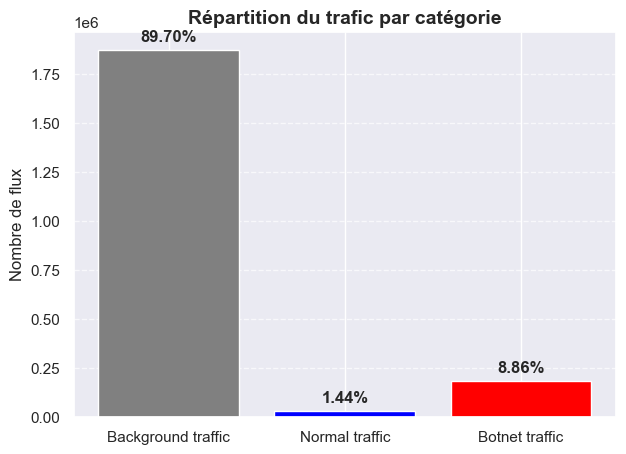

In [198]:
print(df['Label'].value_counts())
hist_of_label_values(df)

In [199]:
df["Prot"].value_counts()

Prot
udp          1629194
tcp           431554
icmp           21856
rtp             1588
igmp            1523
rtcp            1266
arp              432
ipv6-icmp         48
ipv6              12
ipx/spx           11
udt                7
esp                6
pim                6
rsvp               2
rarp               2
gre                1
Name: count, dtype: int64

In [200]:
count_ip_per_label(df)

📊 Nombre d'adresses IP distinctes par Label :
  ➤ Normal: 25 IP
  ➤ Background: 313755 IP
  ➤ Botnet: 10 IP


Label
Background    313755
Botnet            10
Normal            25
Name: SrcIP, dtype: int64

📊 ➤ Calcul de la distribution des labels+protocoles par TimeWindow...


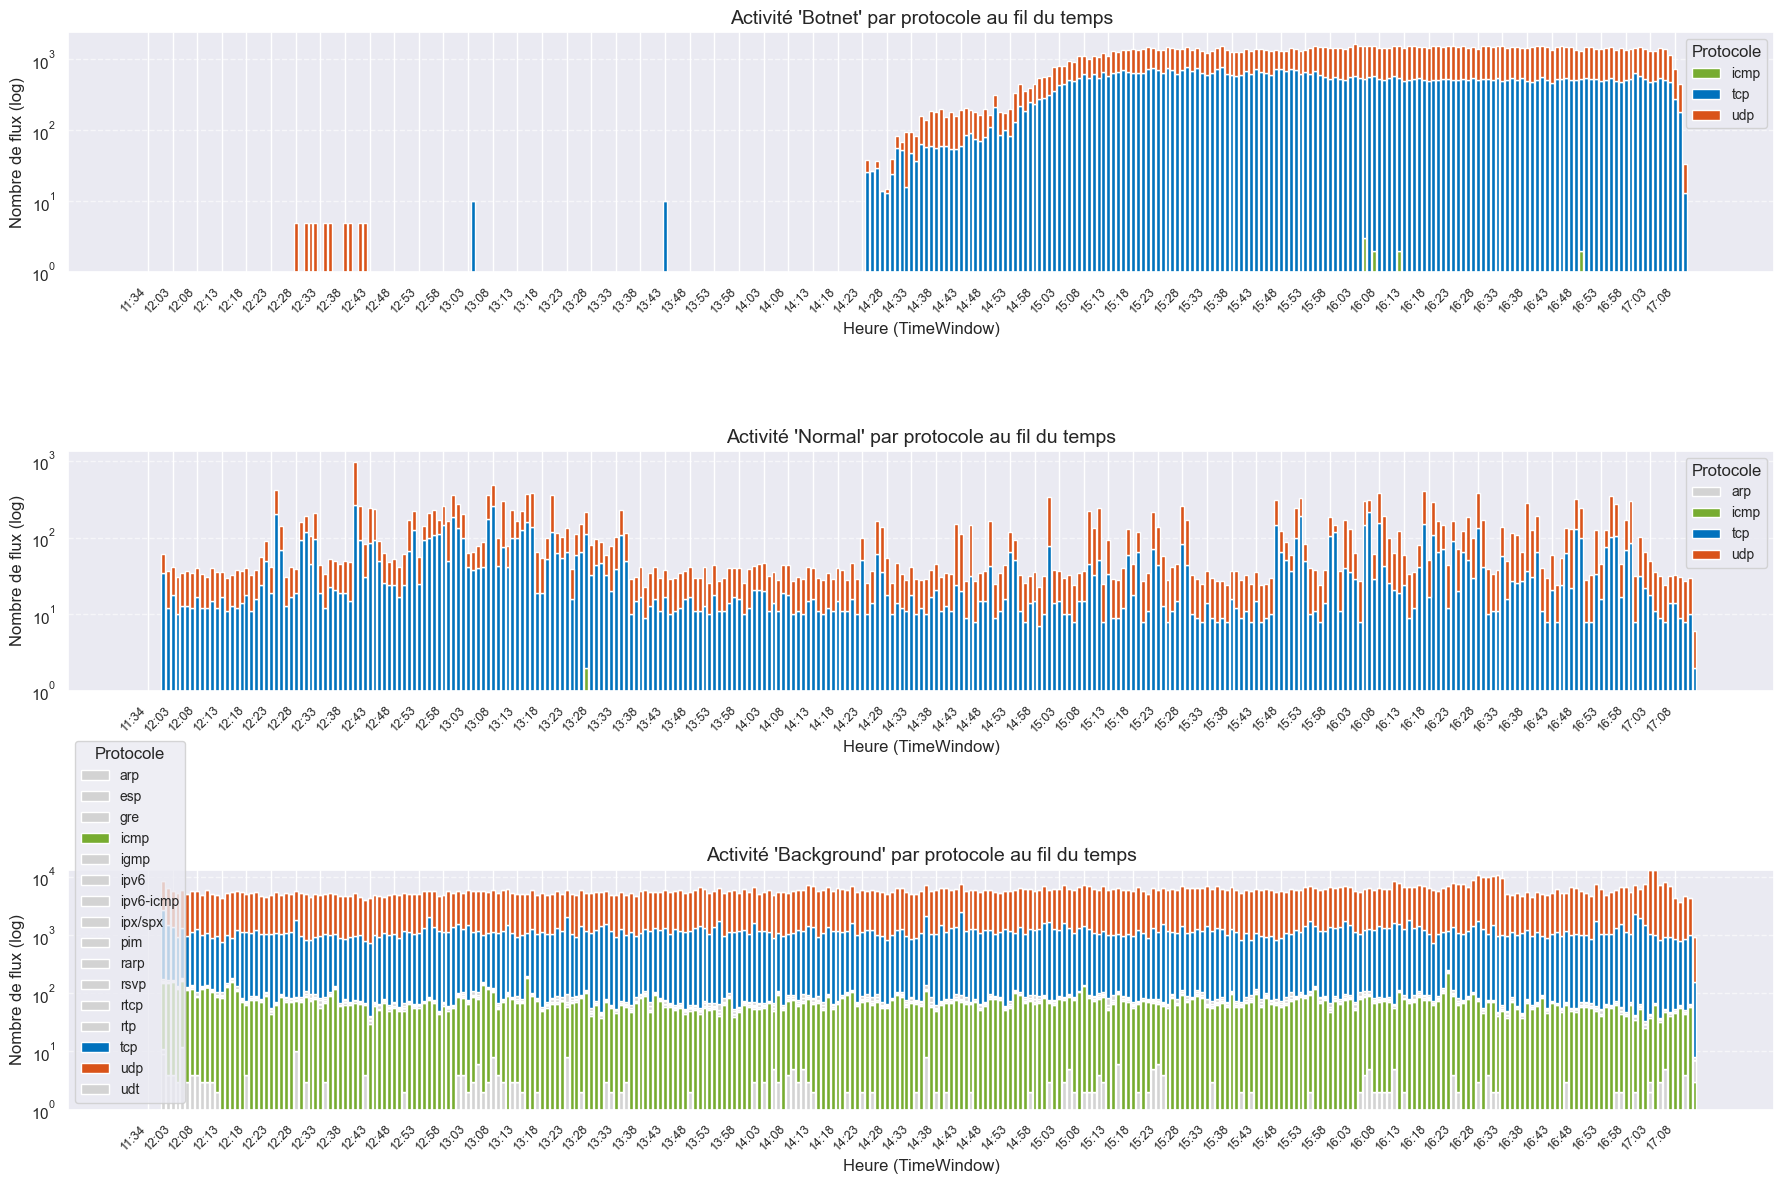

In [201]:
plot_label_distribution_separated(df, time_col="flow_start", x_tick_spacing=5, label_to_show=['Botnet', 'Normal', 'Background'])

📊 ➤ Calcul du nombre de ports distincts par TimeWindow et Label...


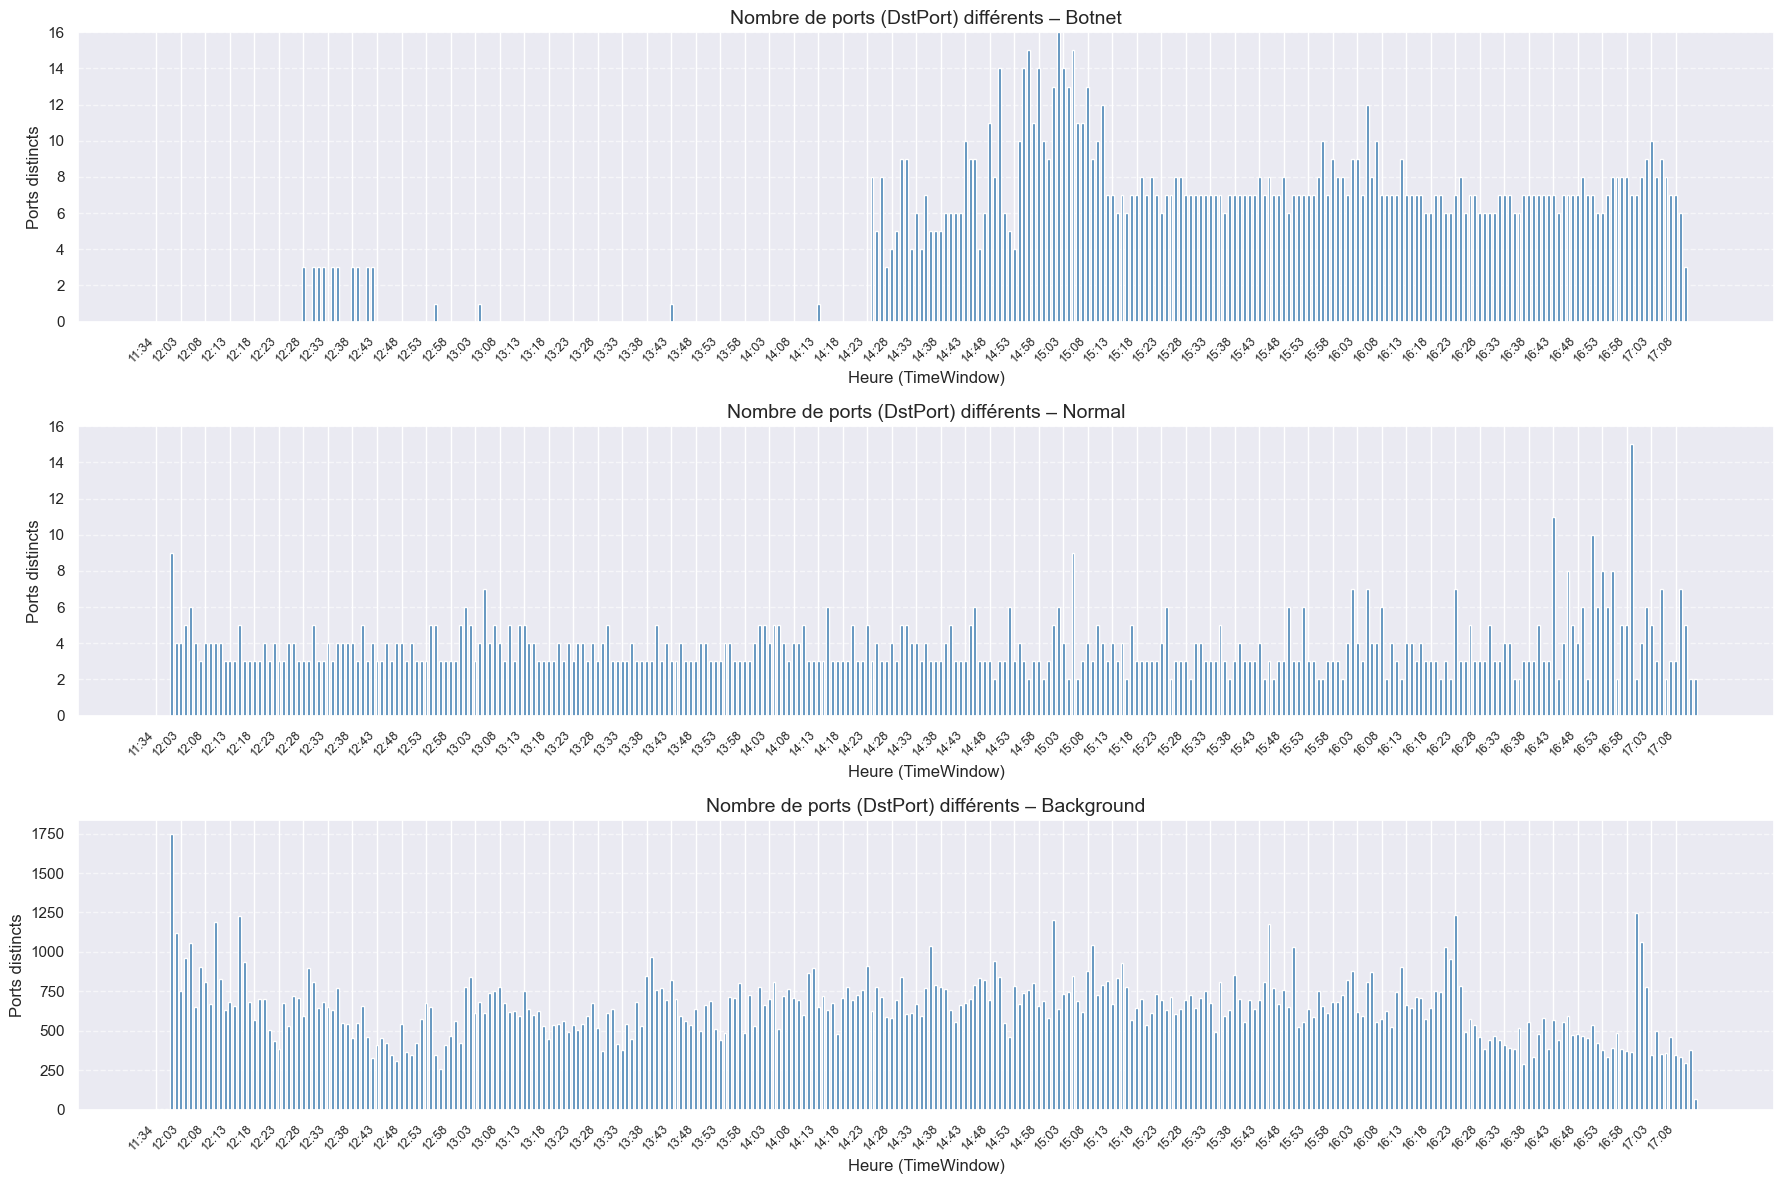

In [205]:
plot_label_distribution_ports_touched(df, time_col="flow_start", x_tick_spacing=5, label_to_show=['Botnet', 'Normal', 'Background'])

In [206]:
print("Adresses IP des Botnets")
print(pd.DataFrame(df[df["Label"] == "Botnet"]["SrcIP"].value_counts()))

Adresses IP des Botnets
               count
SrcIP               
147.32.84.165  22792
147.32.84.192  20305
147.32.84.204  18783
147.32.84.191  18774
147.32.84.206  18553
147.32.84.193  17961
147.32.84.208  17909
147.32.84.205  17535
147.32.84.209  16376
147.32.84.207  15999


In [ ]:
alpha_range = np.linspace(0.005, 0.05, 10)  # ex: [0.005, 0.0175, 0.03, 0.0425, 0.05]
beta_range = np.linspace(0.8, 0.999, 10)     # ex: [0.7, 0.75, ..., 0.95]

best_config, df_summary = optimize_alpha_beta_for_botnet_coverage(df, alpha_range, beta_range, column='SrcIP',min_coverage_pct=0.6, debug=False)

🔁 ➤ Traitement de 160 TimeWindows...


Extraction clusters par TimeWindow:   0%|          | 0/160 [00:00<?, ?it/s]

✅ Extraction terminée sur toutes les TimeWindows.
📈 ➤ Tracé de l'évolution des clusters significatifs...


C:\Users\kira\AppData\Local\Temp\ipykernel_9724\1353206489.py:32: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.

C:\Users\kira\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.



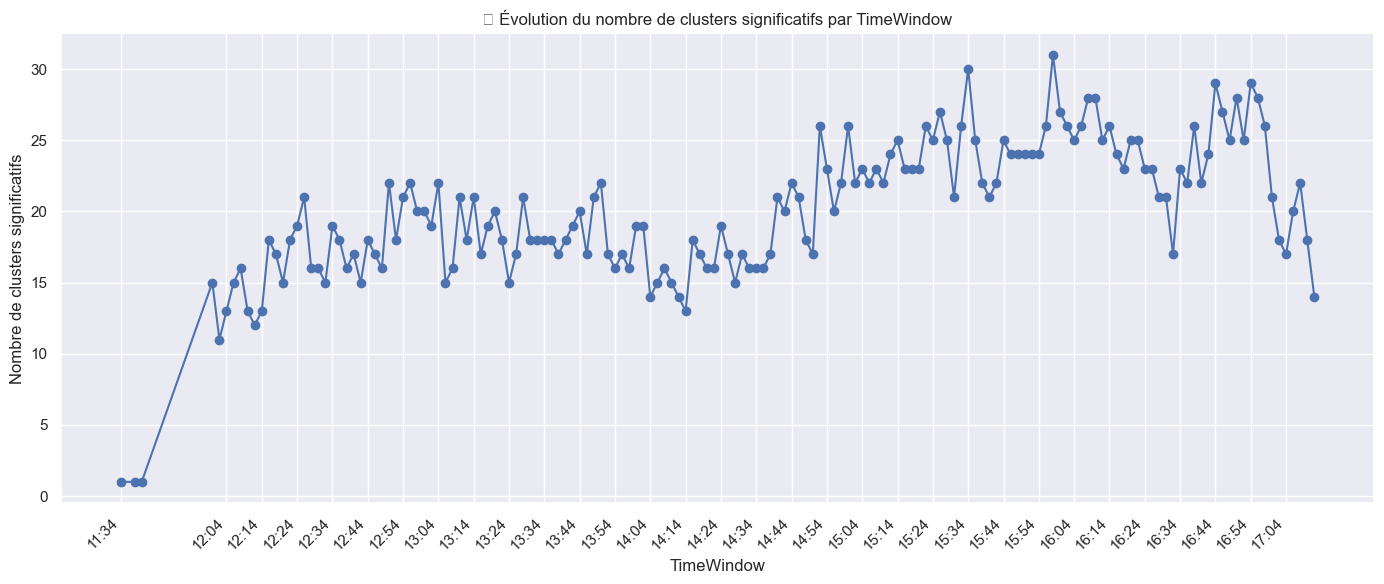


🔍 Nombre de lignes retenues pour l’analyse XU : 1331657
 📊 ➤ Analyse XU sur les clusters significatifs...
🔍 ➤ Traitement XU par TimeWindow (160 fenêtres)...


XU TimeWindow:   0%|          | 0/160 [00:00<?, ?it/s]

✅ XU par TimeWindow terminé.


 📊 ➤ Analyse XU sur toutes les IP pour les statistiques
🔍 ➤ Traitement XU par TimeWindow (160 fenêtres)...


XU TimeWindow:   0%|          | 0/160 [00:00<?, ?it/s]

✅ XU par TimeWindow terminé.


In [208]:
# --- 1. Étape : Extraction des clusters significatifs sur une colonne (par ex. 'SrcIP')
df_clustered, df_log = extract_significant_clusters(
    df, column='SrcIP', alpha0=0.005, beta=0.8000, debug=False, stop_while=5
)
plot_significant_cluster_evolution(df_log)

# --- 2. Filtrage du dataset : uniquement les lignes appartenant aux clusters significatifs
df_significatif = df_clustered[df_clustered['ClusterType'] == 'Significatif']

print(f"\n🔍 Nombre de lignes retenues pour l’analyse XU : {len(df_significatif)}")

# --- 3. Application de l’algorithme XU uniquement sur ce sous-ensemble

custom_profiles = {
    # Comportements typiques de botnets/scanners identifiés :
    
    # BC2 [0,0,2] → Scan horizontal basique / botnet scanner simple
    'scanner_horizontal': np.array([0.1, 0.1, 0.9]),

    # BC20 [2,0,2] → Scanner bruyant, srcPrt aléatoires, dstIP massifs
    'scanner_horizontal_bruyant': np.array([0.9, 0.1, 0.9]),

    #BC6 [0,2,0] → Scan vertical simple
    'scanner_vertical_simple': np.array([0.1, 0.9, 0.1]),

    # BC8 [0,2,2] → Réponse d’une victime potentiellement exposée à divers scanners
    #'victime_multiattaque': np.array([0.1, 0.9, 0.9]),

    # BC5 [0,1,2] → Scan un peu plus varié, intermédiaire
    #'scanner_intermediaire': np.array([0.1, 0.5, 0.9]),

    # BC23 [2,1,2] → Profil de service fortement ciblé par des scanners massifs
    #'cible_botnet': np.array([0.9, 0.5, 0.9]),

    # BC 18 [2,0,0] → Training dataset 10
    'training_BC_10': np.array([0.5, 0.3, 0.15]),
}

print(" 📊 ➤ Analyse XU sur les clusters significatifs...")
df_features = XU_algorithm(df_significatif, ref_profiles=custom_profiles)
display_scrollable_dataframe(df_features, max_height=200)

print(" 📊 ➤ Analyse XU sur toutes les IP pour les statistiques")
df_features_without_pre_cluster = XU_algorithm(df_clustered, ref_profiles=custom_profiles)
display_scrollable_dataframe(df_features_without_pre_cluster.head(20), max_height=200)


🔍 ➤ Agrégation par IP (moyenne des RU)...
📈 ➤ Évaluation des scores de silhouette...


  0%|          | 0/8 [00:00<?, ?it/s]

  ➤ k=2, silhouette=0.5213
  ➤ k=3, silhouette=0.4599
  ➤ k=4, silhouette=0.4517
  ➤ k=5, silhouette=0.4704
  ➤ k=6, silhouette=0.4233
  ➤ k=7, silhouette=0.4228
  ➤ k=8, silhouette=0.2573
  ➤ k=9, silhouette=0.0237


C:\Users\kira\AppData\Local\Temp\ipykernel_9724\667125616.py:55: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.

C:\Users\kira\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.



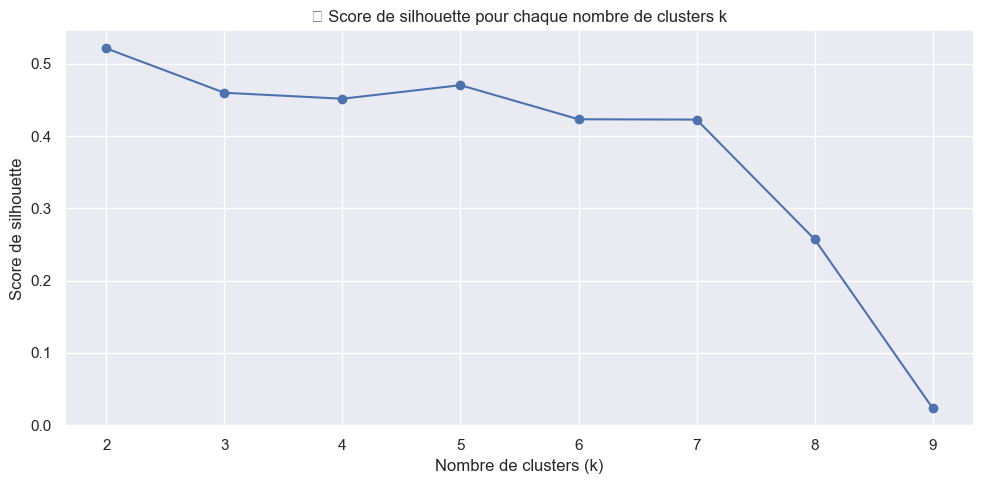


✅ Meilleur nombre de clusters : k=2 (score=0.5213)

📦 ➤ Custom profiles (copier-coller ready au format JSON-like):
custom_profiles = 
{
    "cluster_0": [
        0.75,
        0.59,
        0.515
    ],
    "cluster_1": [
        0.775,
        0.729,
        0.618
    ]
}


In [241]:
silhouette_scores, best_k, kmeans_model, df_botnet_clustered, _ = find_best_k_with_silhouette(df_features_without_pre_cluster, k_range=range(2, 10))

In [242]:
plot_botnet_clusters_3D_plotly(df_botnet_clustered, kmeans_model, force_layout=True)


📍 ➤ Coordonnées des centroïdes trouvés (features RU):
  ➤ Cluster 0 : RU_SrcPort=0.750, RU_DstPort=0.590, RU_DstIP=0.515
  ➤ Cluster 1 : RU_SrcPort=0.775, RU_DstPort=0.729, RU_DstIP=0.618


In [209]:
epsilon_dict = {
    'RU_SrcPort': 0.2,
    'RU_DstPort': 0.2,
    'RU_DstIP': 0.3
}
threshold = 0.8
normalize_anomaly = True

df_classified = apply_threshold_and_categorize_ru(df_features, threshold=threshold, epsilon_dict=epsilon_dict, normalize_anomaly=normalize_anomaly)
df_classified_pre_clusters = apply_threshold_and_categorize_ru(df_features_without_pre_cluster, threshold=threshold, epsilon_dict=epsilon_dict, normalize_anomaly=normalize_anomaly)
display_scrollable_dataframe(df_classified, max_height=200)

📊 ➤ Calcul du score d'anomalie moyen par IP + Label (Normal prioritaire) et ClusterType majoritaire...
📊 Nombre d'adresses IP distinctes par Label :
  ➤ Normal: 25 IP
  ➤ Background: 313731 IP
  ➤ Botnet: 10 IP


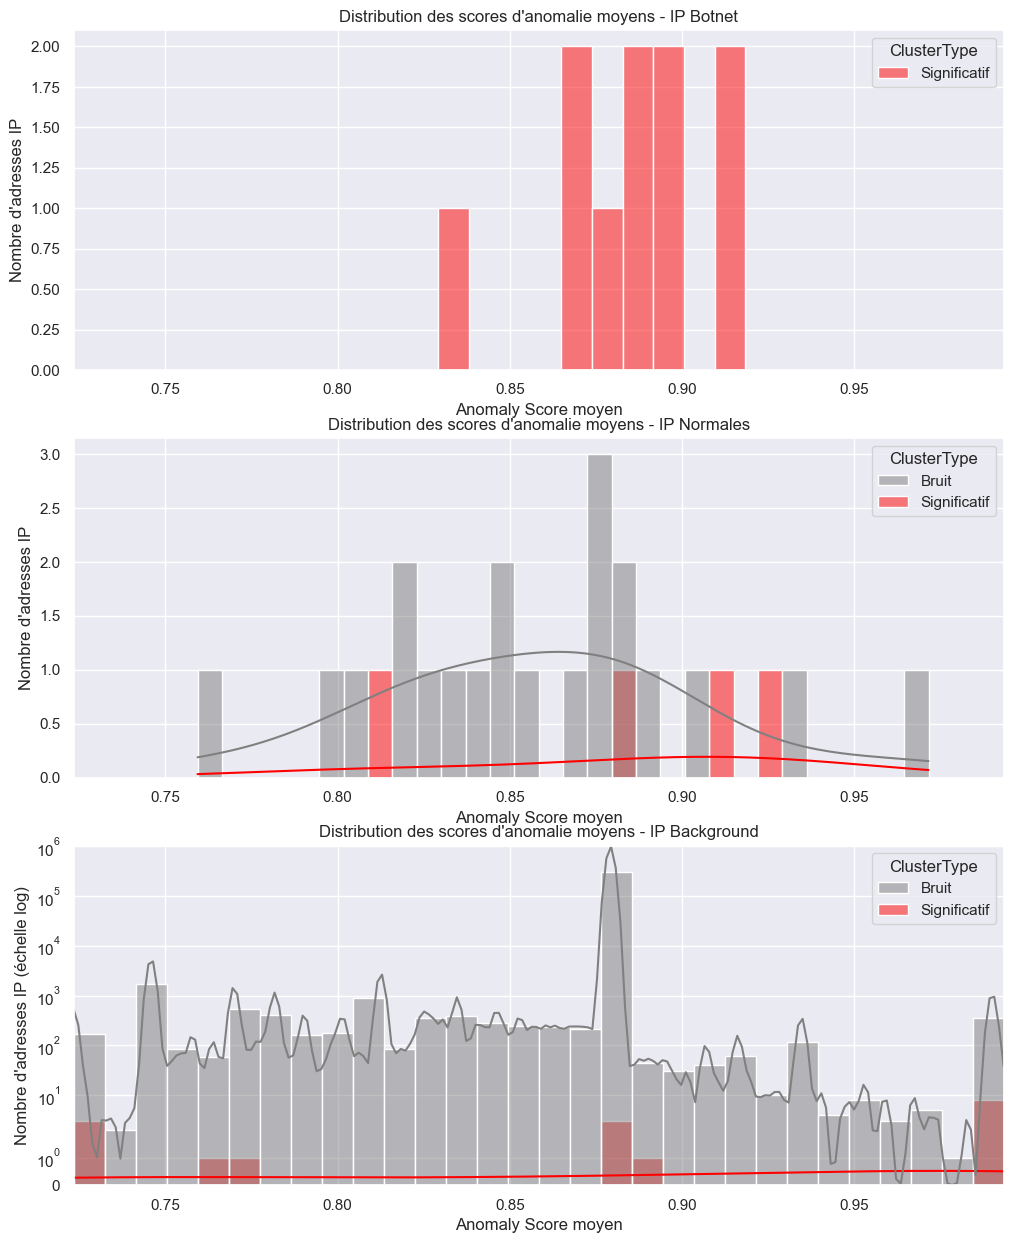

In [216]:
plot_anomly_distributions(df_classified_pre_clusters, debug=False)

In [217]:
df_classified_netflows, df_grouped = classify_netflows_from_XU(df, df_classified)
display_scrollable_dataframe(df_classified_netflows.head(10), max_height=200)

[1/4] 🔗 Jointure sur (SrcIP, TimeWindow) avec df_classified issu de XU...
⚠️ 755851 lignes n'ont pas trouvé de prédiction — elles seront marquées 'Normal'.
[2/4] 📊 Agrégation par (SrcIP, TimeWindow)...


→ Agrégation des netflows:   0%|          | 0/584315 [00:00<?, ?it/s]

[3/4] ✅ Jointure et agrégation terminées.
[4/4] ✅ Total de 584315 groupes d’IP-TimeWindow.


In [255]:
df_metrics, avg_metrics = compute_time_weighted_metrics(df_grouped, take_background=True, alpha=0.01)

print(json.dumps(avg_metrics, indent=4))
display_scrollable_dataframe(df_metrics, max_height=200)

{
    "SUM_tTP": 96.25888384017614,
    "SUM_tTN": 156.48134416531013,
    "SUM_tFP": 3.518655834689894,
    "SUM_tFN": 33.95779023982057,
    "Global_TPR": 0.7392208756694315,
    "Global_TNR": 0.9780084010331882,
    "Global_FPR": 0.021991598966811833,
    "Global_FNR": 0.2607791243305684,
    "Global_Precision": 0.9647349909994198,
    "Global_Accuracy": 0.8708673573173805,
    "Global_ErrorRate": 0.1291326426826195,
    "Global_F1": 0.8370548308034635
}


📊 ➤ Fusion : Botnet Activity + XU Metrics


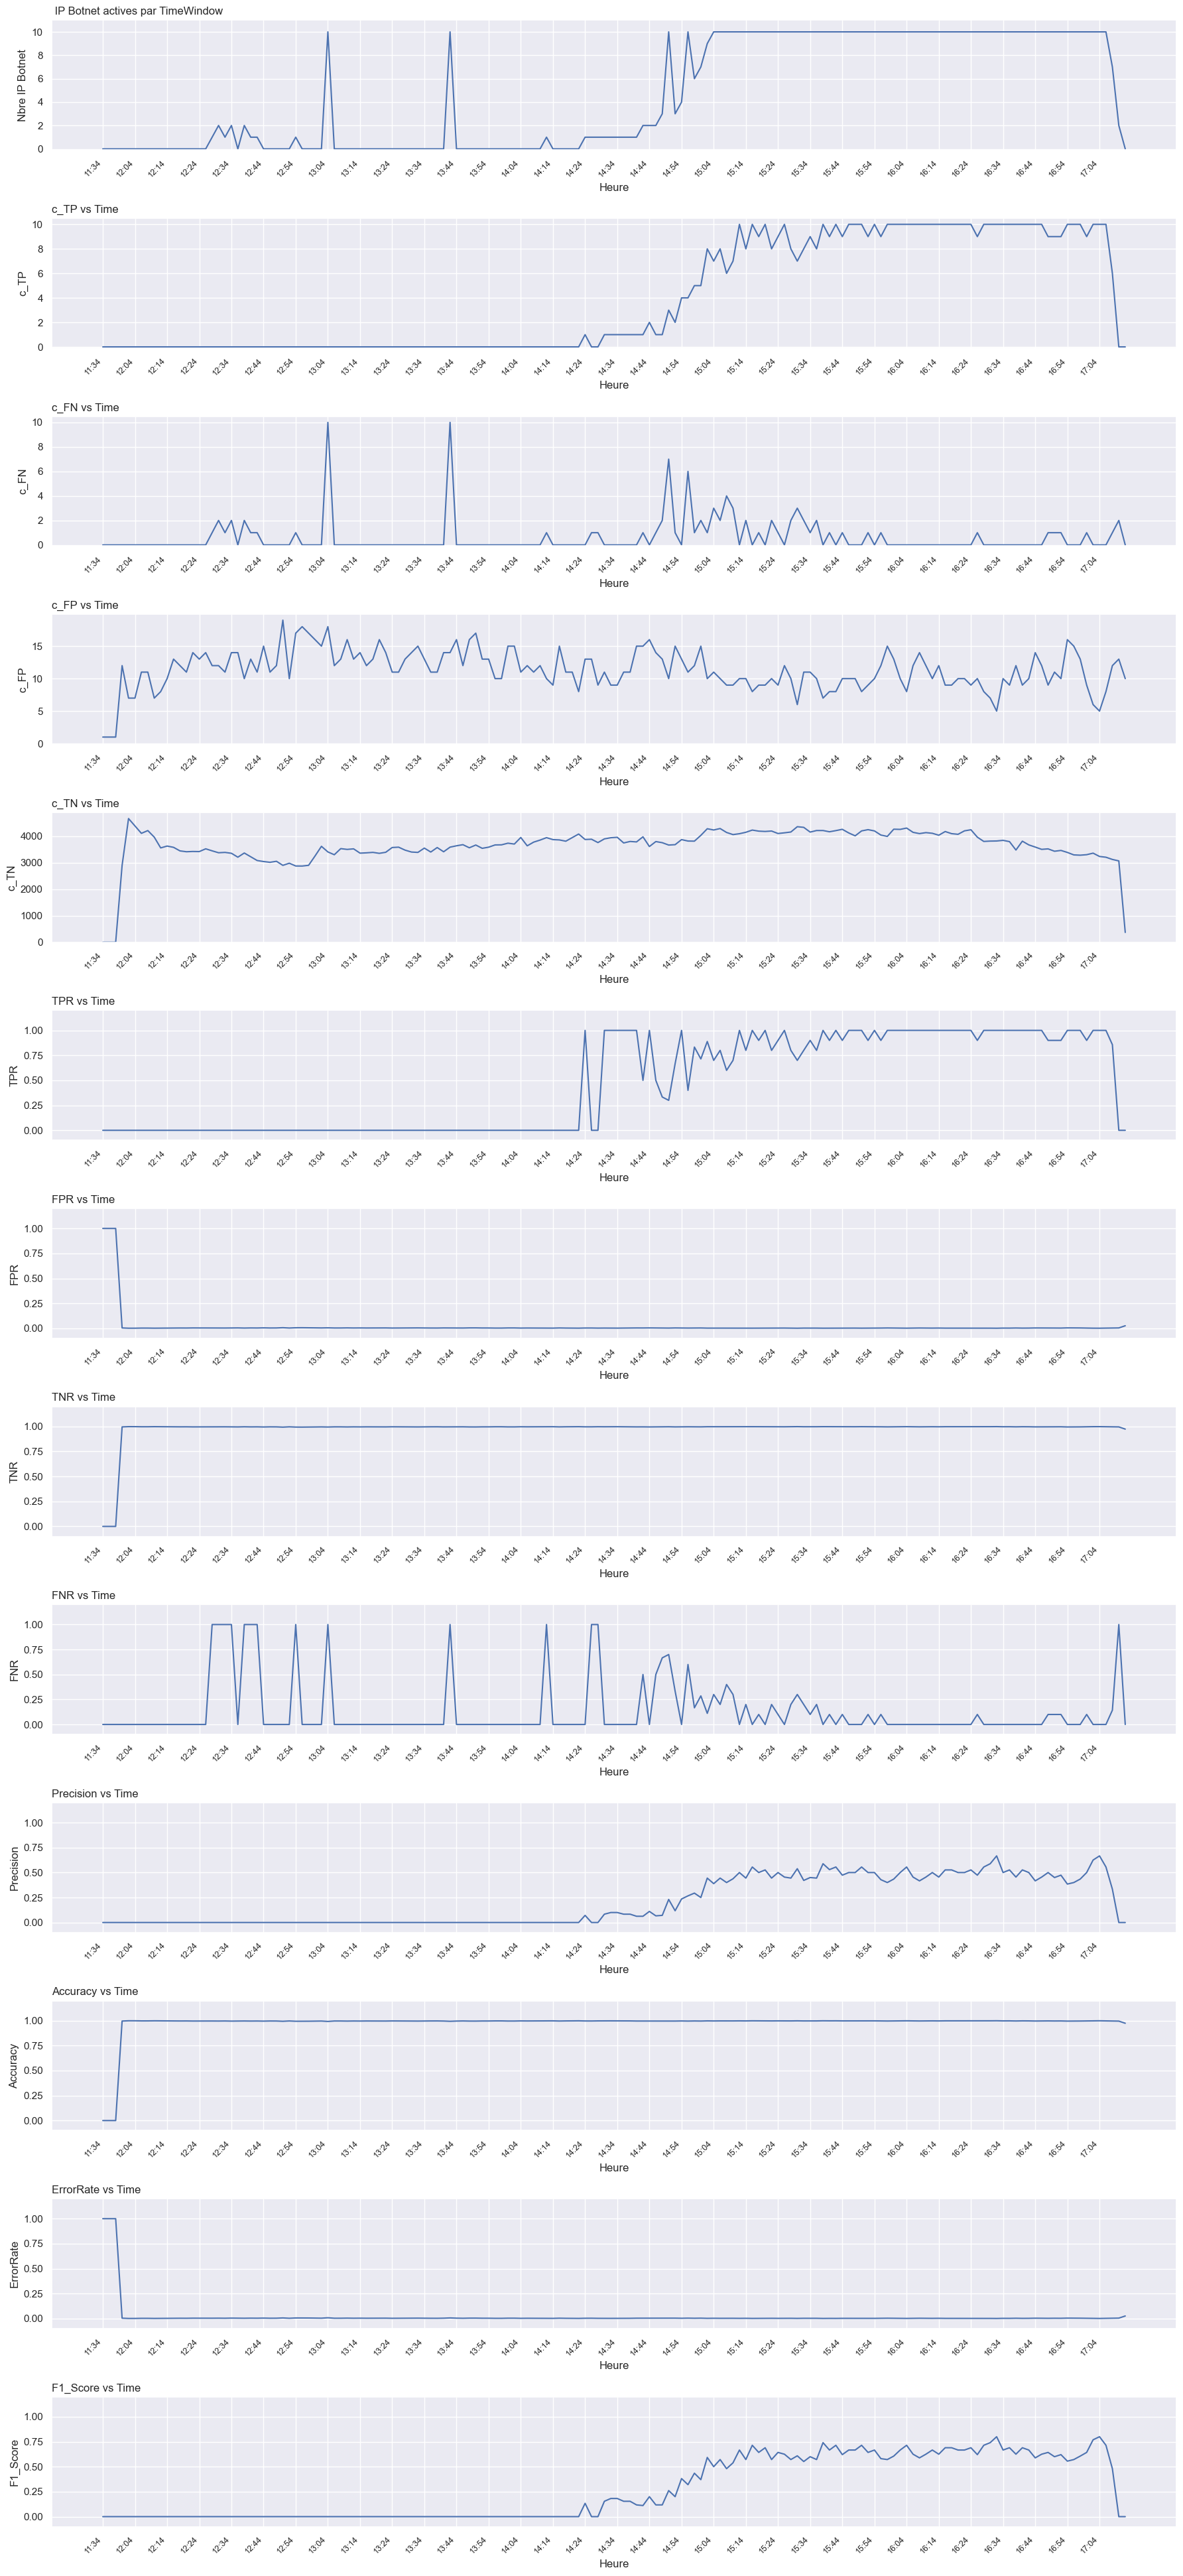

In [252]:
plot_botnet_and_metrics_subplots(df_classified_netflows, df_metrics, x_tick_spacing=5)